In [0]:
#Loading necessary Modules
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow import keras
import gc

In [0]:
#Getting All images in a variable 
path = 'Image_2/Input/Dataset/train'
train_images = []
labels = []
for i in os.listdir(path):
  category = i
  temp_path = os.path.join(path, category)
  try:
    for j in os.listdir(temp_path):
      if j != '.DS_Store': 
        image = cv2.imread(os.path.join(temp_path, j), cv2.IMREAD_GRAYSCALE) # Grayscale for lesser Computation
        train_images.append(image)
        labels.append(category)
  except:
    print('not a directory')

gc.collect()

not a directory


24317

In [0]:
#converting into np arrays
train_images = np.array(train_images)
print(train_images.shape)
labels = np.array(labels)
print(labels.shape)

(440, 800, 800)
(440,)


In [0]:
#shuffling so that dataset remains random
np.random.seed(0) # Setting seed so that train images and labels match up
np.random.shuffle(train_images)
np.random.seed(0)
np.random.shuffle(labels)

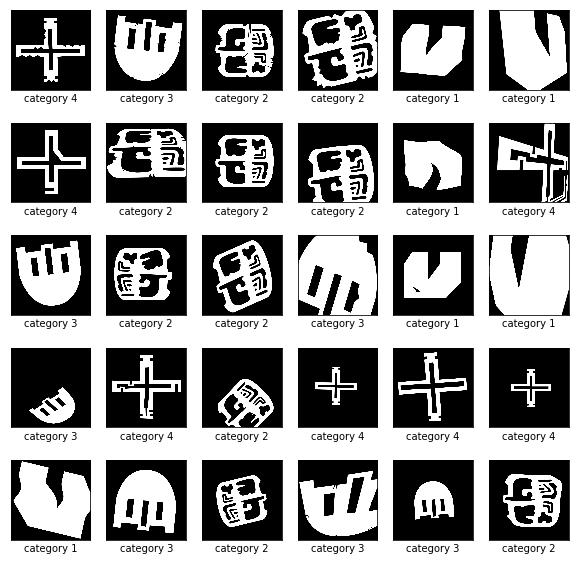

35194

In [0]:
#checking images and labels are matching or not
plt.figure(figsize = (10, 10))
for i in range(30):
  plt.subplot(5, 6, i + 1)
  plt.imshow(train_images[i], cmap = plt.cm.binary)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(labels[i])
plt.show()
gc.collect()

In [0]:
#for prediction purpose
labels, unique = pd.factorize(labels)
labels = np.array(labels)
print(unique)

['category 4' 'category 3' 'category 2' 'category 1']


In [0]:
train_images = train_images / np.float32(255) 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, labels, test_size = 0.2, random_state = 0)

In [0]:
def classifier_model(features, labels, mode):
  
  """ Approach used here is Alex net architecture but with grayscale vgg net computationally expensive 
  and lenet 5 underfitting the data. Estimators are used instead normal session it will easy to predict"""
  
  
  inputs = tf.reshape(features, [-1, 800, 800, 1])
  
  conv_layer1 = tf.layers.conv2d(
      inputs = inputs,
      filters = 96,
      kernel_size = [11, 11],
      padding = 'valid',
      strides = (4, 4),
      activation = tf.nn.relu
  )
  
  
  pool_layer1 = tf.layers.average_pooling2d(
      inputs = conv_layer1,
      pool_size = (3, 3),
      strides = 2
  )
  
  conv_layer2 = tf.layers.conv2d(
      inputs = pool_layer1,
      filters = 256,
      kernel_size = [5, 5],
      padding = 'same',
      strides = (1, 1),
      activation = tf.nn.relu
  )
    
  pool_layer2 = tf.layers.average_pooling2d(
      inputs = conv_layer2,
      pool_size = (3, 3),
      strides = 2
  )
  
  conv_layer3 = tf.layers.conv2d(
      inputs = pool_layer2,
      filters = 384,
      kernel_size = [3, 3],
      padding = 'same',
      strides = (1, 1),
      activation = tf.nn.relu
  )
  conv_layer4 = tf.layers.conv2d(
      inputs = conv_layer3,
      filters = 384,
      kernel_size = [3, 3],
      padding = 'same',
      strides = (1, 1),
      activation = tf.nn.relu
  )
  conv_layer5 = tf.layers.conv2d(
      inputs = pool_layer1,
      filters = 256,
      kernel_size = [3, 3],
      padding = 'same',
      strides = (1, 1),
      activation = tf.nn.relu
  )
  
  pool_layer3 = tf.layers.average_pooling2d(
      inputs = conv_layer5,
      pool_size = (3, 3),
      strides = 2
  )
  
  
  input_layer = tf.contrib.layers.flatten(pool_layer3)
  
  """ Image size is large therefore only fully connected layer """
  fc_layer1 = tf.layers.dense(inputs = input_layer, units = 350, activation = tf.nn.relu)
  
  output = tf.layers.dense(inputs = fc_layer1, units = 4)
  
  prediction = {
      'classes': tf.argmax(output, 1),
      'probabilities': tf.reduce_max(tf.nn.softmax(output), 1)
  }
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode = mode, predictions = prediction)
  
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = output, labels = labels), name = 'loss')
  
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(
        loss = loss,
        global_step = tf.train.get_global_step()
    )
    return tf.estimator.EstimatorSpec(mode = mode, train_op = train_op, loss = loss)
  
  eval_metric_ops = {
      'Accuracy': tf.metrics.accuracy(labels = labels, predictions = prediction['classes'])
  }
  
  return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)
  
  

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
classifier = tf.estimator.Estimator(model_fn = classifier_model)

I0731 09:12:03.402463 140305758091136 estimator.py:1790] Using default config.
W0731 09:12:03.404317 140305758091136 estimator.py:1811] Using temporary folder as model directory: /tmp/tmp4pd2f7hc
I0731 09:12:03.405655 140305758091136 estimator.py:209] Using config: {'_model_dir': '/tmp/tmp4pd2f7hc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b18314518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master

In [0]:
train_fn = tf.estimator.inputs.numpy_input_fn(
    x = X_train,
    y = y_train,
    shuffle = True,
    num_epochs = None,
    batch_size = 10
)

eval_fn = tf.estimator.inputs.numpy_input_fn(
    x = X_test,
    y = y_test,
    shuffle = False,
    num_epochs = 1
)

In [0]:
classifier.train(
    input_fn = train_fn,
    steps = 1000
)

I0731 09:12:03.472924 140305758091136 estimator.py:1145] Calling model_fn.
I0731 09:12:03.746732 140305758091136 estimator.py:1147] Done calling model_fn.
I0731 09:12:03.749355 140305758091136 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I0731 09:12:03.918299 140305758091136 monitored_session.py:240] Graph was finalized.
I0731 09:12:06.784737 140305758091136 session_manager.py:500] Running local_init_op.
I0731 09:12:06.791562 140305758091136 session_manager.py:502] Done running local_init_op.
I0731 09:12:07.026172 140305758091136 basic_session_run_hooks.py:606] Saving checkpoints for 0 into /tmp/tmp4pd2f7hc/model.ckpt.
I0731 09:12:16.420489 140305758091136 basic_session_run_hooks.py:262] loss = 1.3887745, step = 0
I0731 09:12:29.459291 140305758091136 basic_session_run_hooks.py:692] global_step/sec: 7.66912
I0731 09:12:29.461391 140305758091136 basic_session_run_hooks.py:260] loss = 0.05073964, step = 100 (13.041 sec)
I0731 09:12:42.596434 140305758091136 basic_session_r

In [0]:
classifier.evaluate(input_fn = eval_fn, steps = 1)

I0731 09:14:34.964049 140305758091136 estimator.py:1145] Calling model_fn.
I0731 09:14:35.108336 140305758091136 estimator.py:1147] Done calling model_fn.
I0731 09:14:35.130130 140305758091136 evaluation.py:255] Starting evaluation at 2019-07-31T09:14:35Z
I0731 09:14:35.230608 140305758091136 monitored_session.py:240] Graph was finalized.
I0731 09:14:35.237218 140305758091136 saver.py:1280] Restoring parameters from /tmp/tmp4pd2f7hc/model.ckpt-1000
I0731 09:14:35.907438 140305758091136 session_manager.py:500] Running local_init_op.
I0731 09:14:35.919341 140305758091136 session_manager.py:502] Done running local_init_op.
I0731 09:14:36.871639 140305758091136 evaluation.py:167] Evaluation [1/1]
I0731 09:14:36.888078 140305758091136 evaluation.py:275] Finished evaluation at 2019-07-31-09:14:36
I0731 09:14:36.889061 140305758091136 estimator.py:2039] Saving dict for global step 1000: Accuracy = 0.9318182, global_step = 1000, loss = 0.42077515
I0731 09:14:36.936587 140305758091136 estimator

{'Accuracy': 0.9318182, 'global_step': 1000, 'loss': 0.42077515}

In [0]:
test_path = 'Image_2/Input/Dataset/test'
test_images = []
print(len(os.listdir(test_path)))
for i in os.listdir(test_path):
  if i != '.DS_Store':
    test_image = cv2.imread(os.path.join(test_path, i), cv2.IMREAD_GRAYSCALE)
    test_images.append(test_image)

test_images = np.array(test_images)
test_images.shape


31


(30, 800, 800)

In [0]:
test_images = test_images / np.float32(255)

In [0]:
pred_fn = tf.estimator.inputs.numpy_input_fn(
    x = test_images,
    shuffle = False
)

In [0]:
predictions = classifier.predict(
    input_fn = pred_fn,
)

In [0]:
predictions = list(predictions)

I0731 09:20:53.441503 140305758091136 estimator.py:1145] Calling model_fn.
I0731 09:20:53.559527 140305758091136 estimator.py:1147] Done calling model_fn.
I0731 09:20:53.782334 140305758091136 monitored_session.py:240] Graph was finalized.
I0731 09:20:53.787864 140305758091136 saver.py:1280] Restoring parameters from /tmp/tmp4pd2f7hc/model.ckpt-1000
I0731 09:20:54.460375 140305758091136 session_manager.py:500] Running local_init_op.
I0731 09:20:54.465774 140305758091136 session_manager.py:502] Done running local_init_op.


<function matplotlib.pyplot.show>

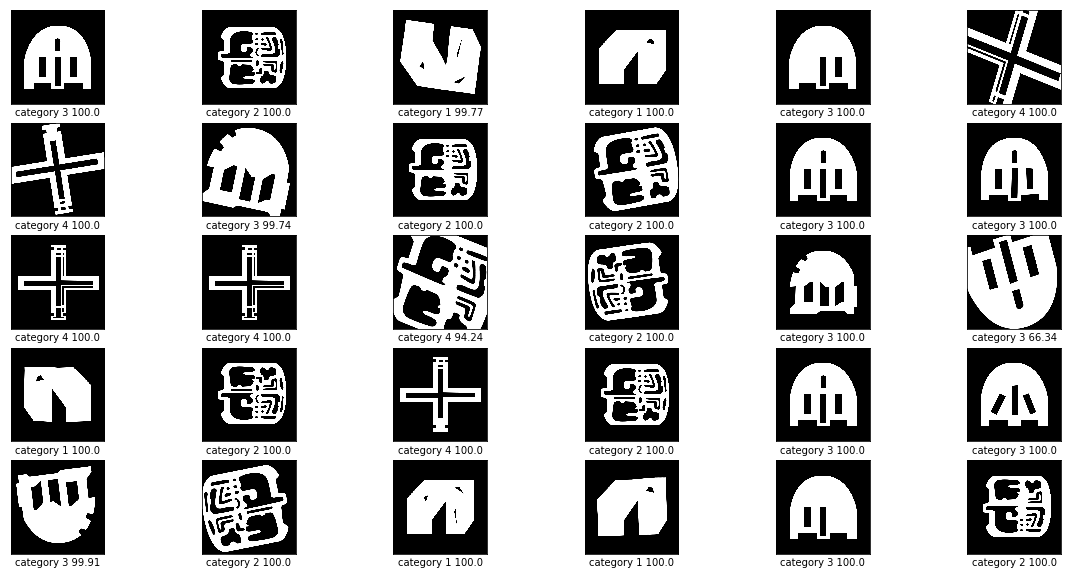

In [0]:
plt.figure(figsize = (20, 10))
for i in range(30):
  plt.subplot(5, 6, i + 1)
  plt.imshow(test_images[i], cmap = plt.cm.binary)
  plt.xticks([])
  plt.yticks([])
  pred = predictions[i]
  category = pred['classes']
  prob = pred['probabilities']
 
  plt.xlabel(str(unique[category]) + ' ' + str(round(prob * 100, 2)))
plt.show